In [2]:
import eurostat
code_renewables = 'nrg_inf_epcrw'  # Electricity production capacities for renewables and wastes
code_other = 'nrg_inf_epc'    # Electricity production capacities by main fuel groups and operator

pars_renewables = eurostat.get_pars(code_renewables)
pars_other = eurostat.get_pars(code_other)
pars_renewables, pars_other

(['freq', 'siec', 'plant_tec', 'unit', 'geo'],
 ['freq', 'siec', 'plant_tec', 'operator', 'unit', 'geo'])

In [3]:
descriptions_renewables = {}
for par in pars_renewables:
    par_values = eurostat.get_par_values(code_renewables, par)
    dic = eurostat.get_dic(code_renewables, par)
    tempdict = {}
    for flag, description in dic:
        if(flag in par_values):
            tempdict[flag] = description
    descriptions_renewables[par] = tempdict
data_renewables = eurostat.get_data(code_renewables)

In [4]:
descriptions_other = {}
for par in pars_other:
    par_values = eurostat.get_par_values(code_other, par)
    dic = eurostat.get_dic(code_other, par)
    tempdict = {}
    for flag, description in dic:
        if(flag in par_values):
            tempdict[flag] = description
    descriptions_other[par] = tempdict
data_other = eurostat.get_data(code_other)

In [5]:
from collections import defaultdict 
descriptions = defaultdict(dict) 
for name in descriptions_other.keys():
    for tip, descript in descriptions_other[name].items():
        descriptions[name][tip] = descript
    if name != 'operator':
        for tip, descript in descriptions_renewables[name].items():
            descriptions[name][tip] = descript

In [6]:

def what_is(descriptor):
    for name, description in descriptions.items():
        if descriptor in description:
            return f'{name}     {descriptor} : {descriptions[name][descriptor]}', 
    return f'{descriptor} does not exsist'

In [7]:
what_is('X9900')

('siec     X9900 : Other fuels n.e.c.',)

In [8]:
countries_only_in_renewables = set(descriptions_renewables['geo'].keys()) - set(descriptions_other['geo'].keys())
countries_only_in_renewables

{'BA', 'GE', 'IS', 'MD', 'UA', 'UK', 'XK'}

In [9]:
import pandas as pd
columns = list(data_other[0])
columns[5] = 'geo'
pandas_data_other = pd.DataFrame(data_other[1:], columns=columns)

columns = list(data_renewables[0])
columns[4] = 'geo'
pandas_data_renewables = pd.DataFrame(data_renewables[1:], columns=columns)


In [10]:
code_pop = 'demo_pjan'#most promising database

pars_pop = eurostat.get_pars(code_pop)

print(pars_pop)

descriptions_pop = {}
for par in pars_pop:
    par_values = eurostat.get_par_values(code_pop, par)
    dic = eurostat.get_dic(code_pop, par)
    tempdict = {}
    for flag, description in dic:
        if(flag in par_values):
            tempdict[flag] = description
    descriptions_pop[par] = tempdict
data_pop = eurostat.get_data(code_pop)

columns = list(data_pop[0])
columns[4] = 'geo'
pandas_data_pop = pd.DataFrame(data_pop[1:], columns=columns)


['freq', 'unit', 'age', 'sex', 'geo']


In [11]:
import numpy as np
AGE = pandas_data_pop['age'] == 'TOTAL'
GENDER = pandas_data_pop['sex'] == 'T'

is_COUNTRY = pandas_data_pop['geo'] == 'SI'

for country in descriptions_renewables['geo'].keys():
    if country != 'EA20' and country != 'EU27_2020':
        is_COUNTRY = np.logical_or(is_COUNTRY, pandas_data_pop['geo'] == country)
condition = np.logical_and(AGE, GENDER)
condition = np.logical_and(condition, is_COUNTRY)
pandas_data_pop_all = pandas_data_pop.loc[condition]

# for year in range(1960, 1990):
#     pandas_data_pop_all = pandas_data_pop_all.drop(str(year), axis=1)
# pandas_data_pop_all = pandas_data_pop_all.drop('2023', axis=1)
pandas_data_pop_all = pandas_data_pop_all.drop('freq', axis=1)
pandas_data_pop_all = pandas_data_pop_all.drop('unit', axis=1)
pandas_data_pop_all = pandas_data_pop_all.drop('age', axis=1)
pandas_data_pop_all = pandas_data_pop_all.drop('sex', axis=1)

In [12]:
pandas_data_pop_all

,geo,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
119,AL,1583800.0,1633800.0,1685800.0,1736838.0,1788404.0,1839866.0,1889715.0,1939430.0,1991765.0,...,2892394.0,2885796.0,2875592.0,2876591.0,2870324.0,2862427.0,2845955.0,2829741.0,2793592.0,2761785.0
121,AT,7030385.0,7064693.0,7107904.0,7151824.0,7199798.0,7247804.0,7293973.0,7350159.0,7403837.0,...,8507786.0,8584926.0,8700471.0,8772865.0,8822267.0,8858775.0,8901064.0,8932664.0,8978929.0,9104772.0
123,BA,3212349.0,3265629.0,3329909.0,3406130.0,3480448.0,3553053.0,3627922.0,3700916.0,3767185.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,BE,9128824.0,9178154.0,9189741.0,9251414.0,9328126.0,9428100.0,9499234.0,9556380.0,9605601.0,...,11180840.0,11237274.0,11311117.0,11351727.0,11398589.0,11455519.0,11522440.0,11554767.0,11617623.0,11742796.0
125,BG,7829246.0,7905502.0,7980734.0,8045158.0,8111132.0,8177547.0,8230788.0,8285325.0,8335126.0,...,7245677.0,7202198.0,7153784.0,7101859.0,7050034.0,7000039.0,6951482.0,6916548.0,6838937.0,6447710.0
128,CY,572000.0,573566.0,575900.0,578900.0,585500.0,588400.0,593200.0,597100.0,601800.0,...,858000.0,847008.0,848319.0,854802.0,864236.0,875899.0,888005.0,896007.0,904705.0,920701.0
129,CZ,9637840.0,9566172.0,9607129.0,9642191.0,9699179.0,9756429.0,9802287.0,9839792.0,9866006.0,...,10512419.0,10538275.0,10553843.0,10578820.0,10610055.0,10649800.0,10693939.0,10494836.0,10516707.0,10827529.0
130,DE,55257088.0,55958321.0,56589148.0,57247246.0,57864509.0,58587451.0,59296591.0,59792934.0,59948474.0,...,80767463.0,81197537.0,82175684.0,82521653.0,82792351.0,83019213.0,83166711.0,83155031.0,83237124.0,84358845.0
132,DK,4565455.0,4593750.0,4629624.0,4665829.0,4703136.0,4741008.0,4777015.0,4817746.0,4852962.0,...,5627235.0,5659715.0,5707251.0,5748769.0,5781190.0,5806081.0,5822763.0,5840045.0,5873420.0,5932654.0
135,EE,1206362.0,1216712.0,1233441.0,1249804.0,1267910.0,1286262.0,1302870.0,1314323.0,1323569.0,...,1315819.0,1314870.0,1315944.0,1315635.0,1319133.0,1324820.0,1328976.0,1330068.0,1331796.0,1365884.0


In [13]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
imputer = KNNImputer(n_neighbors=2, weights="distance")
# imputer = IterativeImputer(max_iter=10, random_state=0)
# imputer = SimpleImputer(max_iter=10, random_state=0)
a = imputer.fit_transform(np.rot90(pandas_data_pop_all.drop(['geo'], axis=1), k=1))
neki = []
a = np.rot90(a, k=3)
for country, pop in zip(pandas_data_pop_all['geo'], a):
    # pop_tmp = [country]
    # for po in pop:
    #    pop_tmp.append(po)
    neki.append(pop) 
neki = np.array(neki)
pandas_data_pop_all_imputed = {}

pandas_data_pop_all_imputed['geo'] = pandas_data_pop_all['geo']
for name, ind in zip(pandas_data_pop_all.columns[1:], range(0, len(pandas_data_pop_all.columns)-1)):
    pandas_data_pop_all_imputed[name] = neki[:, ind]
pandas_data_pop_all_imputed = pd.DataFrame(pandas_data_pop_all_imputed)

is_COUNTRY = pandas_data_pop_all_imputed['geo'] == 'GE'

for country in {'BA', 'FR', 'GE', 'MD', 'ME', 'RS', 'UA', 'XK', 'UK'}:
    is_COUNTRY = np.logical_or(is_COUNTRY, pandas_data_pop_all_imputed['geo'] == country)

for year in range(1960, 1990):
    pandas_data_pop_all_imputed = pandas_data_pop_all_imputed.drop(str(year), axis=1)
pandas_data_pop_all_imputed = pandas_data_pop_all_imputed.drop('2023', axis=1)

pandas_data_pop_all_imputed[is_COUNTRY]

,geo,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
123,BA,4.499203e+06,4.517921e+06,4.373406e+06,4.231546e+06,4.105344e+06,3.656170e+06,3.668079e+06,3.727439e+06,3.549736e+06,...,3.840559e+06,3.840912e+06,3.841042e+06,3.841082e+06,3.841100e+06,3.841115e+06,3.841127e+06,3.841138e+06,3.841147e+06,3.841155e+06
145,FR,5.845535e+07,5.831344e+07,5.860485e+07,5.888593e+07,5.910432e+07,5.931514e+07,5.952230e+07,5.972639e+07,5.993488e+07,...,6.560035e+07,6.616598e+07,6.645815e+07,6.663839e+07,6.680982e+07,6.702622e+07,6.717764e+07,6.732022e+07,6.765668e+07,6.787192e+07
147,GE,4.386667e+06,4.387313e+06,4.387446e+06,4.387637e+06,4.387880e+06,4.388223e+06,4.388751e+06,4.389514e+06,4.414449e+06,...,4.494805e+06,4.490498e+06,3.729500e+06,3.720400e+06,3.718200e+06,3.729633e+06,3.723464e+06,3.716858e+06,3.728573e+06,3.688647e+06
158,MD,3.631515e+06,3.631673e+06,3.631705e+06,3.631752e+06,3.631811e+06,3.631895e+06,3.632024e+06,3.632210e+06,3.638570e+06,...,3.559497e+06,3.557634e+06,3.555159e+06,3.552769e+06,3.550852e+06,3.305605e+06,3.008239e+06,2.580148e+06,2.597107e+06,2.562971e+06
159,ME,6.072060e+05,6.071526e+05,6.071416e+05,6.071259e+05,6.071058e+05,6.070775e+05,6.070338e+05,6.069706e+05,6.048931e+05,...,6.208930e+05,6.215210e+05,6.220990e+05,6.222180e+05,6.223870e+05,6.223590e+05,6.221820e+05,6.218730e+05,6.207390e+05,6.176830e+05
167,RS,7.528516e+06,7.528004e+06,7.528025e+06,7.527865e+06,7.527736e+06,7.527608e+06,7.527488e+06,7.527667e+06,7.531659e+06,...,7.181505e+06,7.146759e+06,7.114393e+06,7.076372e+06,7.040272e+06,7.001444e+06,6.963764e+06,6.926705e+06,6.871547e+06,6.797105e+06
174,UA,4.845533e+07,4.846446e+07,4.846634e+07,4.846904e+07,4.847247e+07,4.847731e+07,4.848479e+07,4.849558e+07,4.883785e+07,...,4.537269e+07,4.524589e+07,4.275966e+07,4.259088e+07,4.241490e+07,4.221677e+07,4.198356e+07,4.173278e+07,4.141872e+07,4.099770e+07
175,UK,5.715697e+07,5.733820e+07,5.751159e+07,5.764921e+07,5.778802e+07,5.794347e+07,5.809459e+07,5.823931e+07,5.839460e+07,...,6.390534e+07,6.435120e+07,6.485339e+07,6.537904e+07,6.584414e+07,6.627358e+07,6.664711e+07,6.702554e+07,6.691407e+07,6.687950e+07
176,XK,2.000322e+06,1.999806e+06,1.999709e+06,1.999587e+06,1.999449e+06,1.999275e+06,1.999039e+06,1.998735e+06,1.998388e+06,...,1.948402e+06,1.783113e+06,1.775939e+06,1.771604e+06,1.783531e+06,1.798506e+06,1.795666e+06,1.782115e+06,1.798186e+06,1.773971e+06


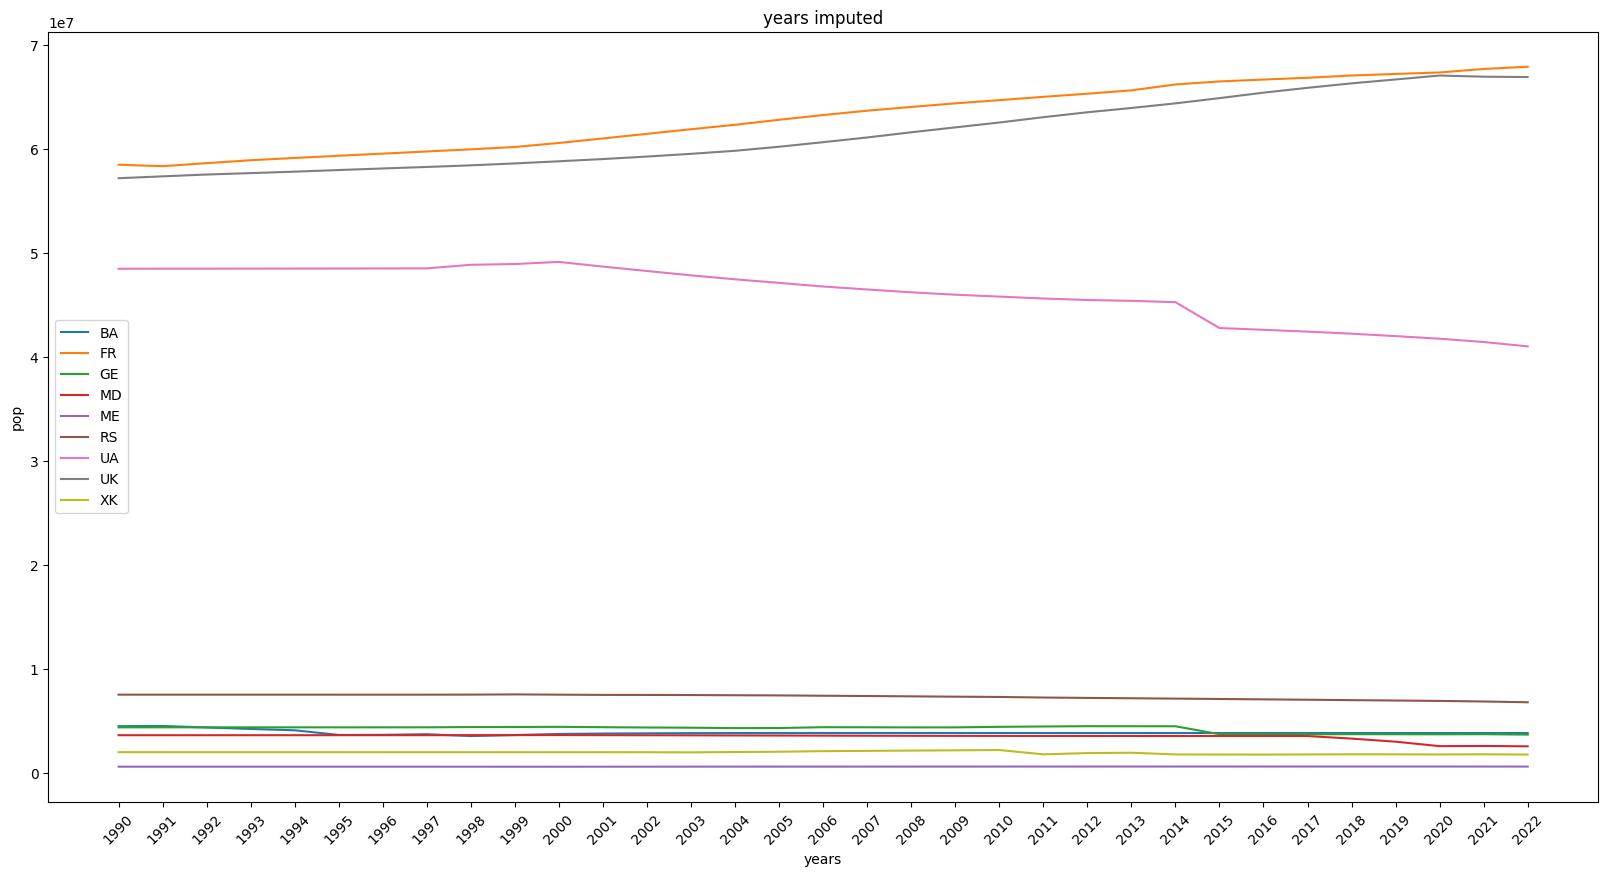

In [32]:
import matplotlib
import matplotlib.pyplot as plt

years = pandas_data_pop_all_imputed[is_COUNTRY].columns.tolist()[1:]

# vosta_energij_po_vrsti.plot(x='1990', y='1992')
# fig2 = {'R5100', 'X9900', 'RA500', 'RA200'}
#         CF         N9000      R5100    RA100      RA200    RA300     RA400      RA500    X9900
# colors= ['#232023', '#39FF14', 'green', '#007fff', 'cyan', '#787276', '#a91b0d', 'navy', '#FF00FF']

plt.figure(figsize=(20, 10))
for row in pandas_data_pop_all_imputed[is_COUNTRY].values:
    plt.plot(years, row[1:], label=row[0])

# plt.subplot(1, 2, 1)
plt.ylabel('pop')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('years imputed')
plt.legend();

In [15]:
what_is('MD')

('geo     MD : Moldova',)

In [16]:
pd.set_option('display.max_columns', 100) #default 20

In [17]:
not_in_energy = []
for geo in pandas_data_pop_all['geo']:
    if  what_is(geo)[-6:] == 'exsist':
        not_in_energy.append(geo)

In [18]:
for name in not_in_energy:
    pandas_data_pop_all = pandas_data_pop_all.drop(pandas_data_pop_all[pandas_data_pop_all['geo'] == name].index)

In [19]:

import numpy as np
is_PRODUCING = pandas_data_other['operator'] == 'PRR_MAIN'
is_SI = pandas_data_other['geo'] == 'SI'
is_ACTIVE =  pandas_data_other['plant_tec'] == 'CAP_NET_ELC'
condition = np.logical_and(is_PRODUCING, is_ACTIVE)
condition = np.logical_and(condition, is_SI)
pandas_data_other.loc[condition]

,freq,siec,plant_tec,operator,unit,geo,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
69,A,CF,CAP_NET_ELC,PRR_MAIN,MW,SI,0.0,0.0,1060.0,1010.0,1020.0,1013.0,1013.0,1013.0,1013.0,1013.0,1019.0,1238.0,1257.0,1260.0,1257.0,1279.0,1287.0,1289.0,1234.0,1242.0,1204.0,1213.0,1227.0,1214.0,1192.0,1086.0,1272.0,1285.774,1467.478,1467.816,1470.529,1528.811,1527.271
285,A,N9000,CAP_NET_ELC,PRR_MAIN,MW,SI,0.0,0.0,632.0,632.0,664.0,664.0,664.0,664.0,664.0,664.0,656.0,656.0,656.0,656.0,656.0,656.0,666.0,666.0,666.0,666.0,666.0,688.0,688.0,688.0,688.0,688.0,688.0,688.000,688.000,688.000,688.000,688.000,688.000
501,A,RA100,CAP_NET_ELC,PRR_MAIN,MW,SI,728.0,728.0,728.0,728.0,728.0,730.0,707.0,707.0,783.0,788.0,753.0,797.0,844.0,868.0,869.0,875.0,905.0,906.0,913.0,954.0,1138.0,1137.0,1138.0,1183.0,1180.0,1179.0,1177.0,1230.926,1227.716,1230.090,1230.273,1230.305,1224.228
573,A,RA110,CAP_NET_ELC,PRR_MAIN,MW,SI,728.0,728.0,728.0,728.0,728.0,730.0,707.0,707.0,783.0,788.0,753.0,797.0,844.0,868.0,869.0,875.0,905.0,906.0,913.0,954.0,958.0,957.0,958.0,1003.0,1000.0,999.0,997.0,1050.926,1047.716,1050.090,1050.273,1050.305,1044.228
789,A,RA120,CAP_NET_ELC,PRR_MAIN,MW,SI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
1005,A,RA130,CAP_NET_ELC,PRR_MAIN,MW,SI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.000,180.000,180.000,180.000,180.000,180.000
1221,A,RA200,CAP_NET_ELC,PRR_MAIN,MW,SI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
1437,A,RA300,CAP_NET_ELC,PRR_MAIN,MW,SI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0,3.0,3.300,3.300,3.300,3.300,3.328,3.328
1509,A,RA310,CAP_NET_ELC,PRR_MAIN,MW,SI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
1725,A,RA320,CAP_NET_ELC,PRR_MAIN,MW,SI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000


In [20]:
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110','RA110ROR', 'RA120', 'RA130']}
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110', 'RA120', 'RA130']}
# data = eurostat.get_data(code, filter_pars=my_filter_pars)
# data[1:]

In [21]:
import matplotlib
import matplotlib.pyplot as plt

# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110','RA110ROR', 'RA120', 'RA130']}
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110', 'RA120', 'RA130']}
# data = eurostat.get_data(code_renewables, filter_pars=my_filter_pars)

3. Keri tip energije proizvaja največ elektrike v evropi in katere države najbolj prispevajo k temu.

In [22]:
siec_not_to_include = {'RA110','RA120','RA130','RA310','RA320','RA410','RA420','RA420AC',
                       'RA420DC','R5210P','R5220P','R5290','R5300','RA110ROR','RA420KW20-1000',
                       'RA420KW30-1000','RA420KW30-1000_OG','RA420KW30-1000_RT','RA420KW_LT10',
                       'RA420KW_LT20','RA420KW_LT30','RA420KW_LT30_OG','RA420KW_LT30_RT','RA420MW_GT1',
                       'RA420MW_GT1_OG','RA420MW_GT1_RT','RA420OG','W6000','W6100','W6200','TOTAL'}

In [23]:
####   filtriranje data setov

# is_PRODUCING = pandas_data_renewables['operator'] == 'PRR_MAIN'
# is_TOTAL = pandas_data_renewables['siec'] != 'TOTAL'
is_ACTIVE =  pandas_data_renewables['plant_tec'] == 'CAP_NET_ELC'
is_GEO = np.logical_and(pandas_data_renewables['geo'] != 'EA20', pandas_data_renewables['geo'] != 'EU27_2020')
for country in countries_only_in_renewables:
    is_GEO = np.logical_and(is_GEO, pandas_data_renewables['geo'] != country)
condition = np.logical_and(is_GEO, is_ACTIVE)
# condition = np.logical_and(condition, is_TOTAL)
# condition = np.logical_and(condition, is_GEO)
condition_2 = condition
# pandas_data_renewables.loc[condition]

is_PRODUCING = pandas_data_other['operator'] == 'PRR_MAIN'
# is_TOTAL = pandas_data_other['siec'] != 'TOTAL'
is_ACTIVE =  pandas_data_other['plant_tec'] == 'CAP_NET_ELC'
is_GEO = np.logical_and(pandas_data_other['geo'] != 'EA20', pandas_data_other['geo'] != 'EU27_2020')
condition = np.logical_and(is_PRODUCING, is_ACTIVE)
# condition = np.logical_and(condition, is_TOTAL)
condition = np.logical_and(condition, is_GEO)
condition_1 = condition
# pandas_data_other.loc[condition]

In [24]:
####  ustvarjanje zdruzenega dataseta

dictNeki = {}
dictNeki['siec'] = []
for year in range(1990, 2023):
    dictNeki[str(year)] = []
for siec in np.unique(pandas_data_renewables['siec']):
    if siec in siec_not_to_include:
        continue
    dictNeki['siec'].append(siec)
    con = np.logical_and(pandas_data_renewables['siec'] == siec, condition_2)
    for year in range(1990, 2023):
        dictNeki[str(year)].append(np.sum(pandas_data_renewables.loc[con][str(year)]))


for siec in np.unique(pandas_data_other['siec']):
    if siec in siec_not_to_include or siec in dictNeki['siec']:
        continue
    dictNeki['siec'].append(siec)
    con = np.logical_and(pandas_data_other['siec'] == siec, condition_1)
    for year in range(1990, 2023):
        dictNeki[str(year)].append(np.sum(pandas_data_other.loc[con][str(year)]))
    
vosta_energij_po_vrsti = pd.DataFrame(dictNeki)

In [25]:
vosta_energij_po_vrsti = vosta_energij_po_vrsti.sort_values('siec')
vosta_energij_po_vrsti

,siec,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
6,CF,235565.000,252358.000,255609.000,257903.000,259559.550,267870.350,272918.350,276630.550,280427.550,289130.550,306312.412,308237.633,313232.633,312819.583,320702.492,330497.118,338485.646,344841.034,350068.028,357109.177,370134.056,409099.783,416520.530,414216.652,417478.044,407882.962,400412.277,395786.297,401302.616,393581.872,386574.460,374376.110,373738.979
7,N9000,110267.000,111444.000,113162.000,114559.000,114225.000,116223.000,117837.000,120175.000,123099.000,124657.000,124851.000,124882.000,126297.000,125416.000,124555.000,123142.000,122837.000,121850.000,122152.000,121684.000,120866.000,121424.000,113237.000,113065.000,113578.000,112497.000,112581.000,111550.590,111266.590,109980.590,106034.590,105111.590,100199.590
0,R5100,3028.000,3081.000,3409.000,3515.000,3727.000,3931.595,4169.396,4063.681,4069.777,4528.246,5265.461,5694.041,5963.134,6977.887,7510.942,9391.990,10510.780,10221.852,11005.763,11935.317,12683.326,13302.658,13546.365,13211.156,14101.276,14299.223,14421.788,15148.744,15724.052,15435.915,15418.069,16539.352,17362.386
1,RA100,156948.000,158355.000,161279.000,163557.000,165170.000,171909.723,173322.723,174386.723,174821.723,176664.723,178813.023,179192.797,180374.797,181212.797,183271.923,186238.998,186818.107,188174.200,189622.961,191752.501,194087.561,197077.536,200878.905,205326.253,207060.033,211572.345,214482.437,215977.623,217682.909,218683.285,222625.466,223913.789,225563.975
2,RA200,517.000,590.000,494.000,494.000,498.000,498.000,513.000,557.000,577.000,617.000,622.000,605.000,700.000,738.000,673.000,700.915,719.915,722.915,729.915,803.915,854.915,888.815,945.415,1106.915,1242.915,1461.665,1663.074,1912.105,2143.923,2381.093,2484.193,2552.510,2571.628
3,RA300,443.981,613.859,812.449,1073.599,1476.737,2233.999,3119.721,4237.547,5907.682,8724.645,12329.515,16876.953,22720.631,27367.316,33316.737,39046.480,45929.090,53909.798,60870.284,72067.527,80682.009,89647.530,100111.041,109209.385,120144.961,132580.551,144662.597,156769.235,166263.664,178198.058,190486.922,204157.228,220565.522
4,RA400,11.000,12.000,28.000,36.000,41.000,52.000,67.000,86.000,104.000,128.000,182.072,279.284,360.748,595.459,1301.974,2274.187,3230.924,4974.133,10373.182,16999.366,30616.219,53288.952,71045.230,79715.838,83680.042,87960.179,92360.983,99675.852,109162.823,126262.083,145139.276,172209.877,215484.754
5,RA500,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,213.000,215.000,218.000,219.000,218.000,216.000,215.000,215.000,218.000,216.000,216.000,215.022,216.205,223.284,225.804,223.125,225.020,224.066,223.198,218.863,216.561,215.988,216.866
8,X9900,15.000,15.000,19.000,23.000,37.450,46.650,53.650,64.450,64.450,64.450,208.450,142.450,155.450,373.450,194.450,302.450,389.450,370.450,382.450,421.795,445.295,441.295,442.295,439.295,470.295,844.595,860.595,903.969,888.758,1535.416,1203.463,1579.812,3351.799


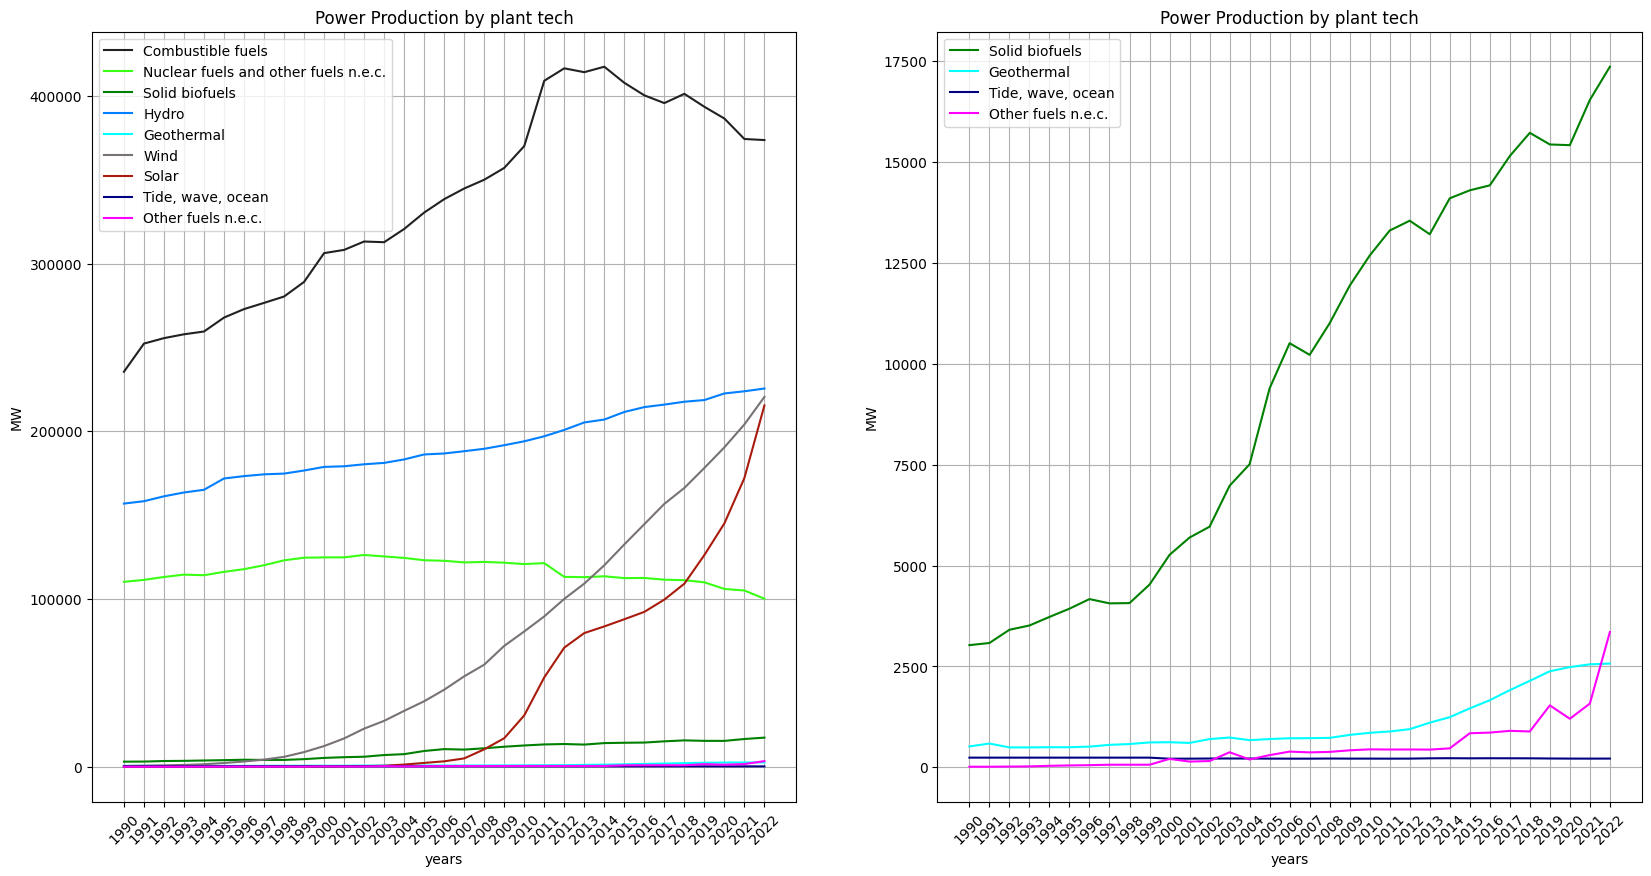

In [26]:
import matplotlib
import matplotlib.pyplot as plt

years = vosta_energij_po_vrsti.columns.tolist()[1:]

# vosta_energij_po_vrsti.plot(x='1990', y='1992')
fig2 = {'R5100', 'X9900', 'RA500', 'RA200'}
#         CF         N9000      R5100    RA100      RA200    RA300     RA400      RA500    X9900
colors= ['#232023', '#39FF14', 'green', '#007fff', 'cyan', '#787276', '#a91b0d', 'navy', '#FF00FF']

plt.figure(figsize=(20, 10))
for row, colour in zip(vosta_energij_po_vrsti.values, colors):
    if row[0] in fig2:
        plt.subplot(1, 2, 2)
        plt.plot(years, row[1:], label=descriptions['siec'][row[0]], color=colour)
    plt.subplot(1, 2, 1)
    plt.plot(years, row[1:], label=descriptions['siec'][row[0]], color=colour)

plt.subplot(1, 2, 1)
plt.ylabel('MW')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('Power Production by plant tech')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.ylabel('MW')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('Power Production by plant tech')
plt.grid(True)
plt.legend()

plt.show()


In [27]:
# pandas_data_other.loc[condition].values

In [28]:

# my_filter_pars = {'geo' : list(descriptions['geo'].keys())[2:] ,'siec' : 'W6100'}
# # my_filter_pars = {'geo' : ['IS'] ,'siec' : 'RA110ROR'}
# data = eurostat.get_data(code_renewables, filter_pars=my_filter_pars)

In [29]:
# plt.figure(figsize=(20, 12))
# # for i in range(1, len(data)):
# #     plt.plot(data[0][5:], data[i][5:], label = str(descriptions['geo'][data[i][4]]))
# for i in range(1, len(pandas_data_other.loc[condition].values)):
#     plt.plot(range(1990, 2022), pandas_data_other.loc[condition].values[i][5:], label = str(descriptions['geo'][data[i][4]]))
# plt.xlabel('year')
# plt.ylabel('MW')

# plt.legend();

In [30]:
# my_filter_pars = {'geo' : ['NO', 'FR', 'DE'] ,'siec' : 'W6100'}
# data = eurostat.get_data(code, filter_pars=my_filter_pars)

In [31]:
# plt.figure(figsize=(20, 12))
# for i in range(1, len(data)):
#     plt.plot(data[0][5:], data[i][5:], label = str(descriptions['geo'][data[i][4]]))
# plt.xlabel('year')
# plt.ylabel('MW')

# plt.legend();